In [272]:
import folium
from folium.plugins import MarkerCluster, FeatureGroupSubGroup, HeatMap

import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import requests
from bs4 import BeautifulSoup

import numpy as np

import os

In [10]:
pd.options.display.max_rows = 4000

In [ ]:
#%env TL_API= key_goes_here

In [18]:
params = {}

## Getting Translink Bus Stop Data

In [19]:
def get_data(params):
    url = "https://api.translink.ca/rttiapi/v1/stops"
    params['apikey'] = os.environ['TL_API']
    params['radius'] = 2000
    
    return requests.get(url, params)

In [20]:
frames = []

In [21]:
# move west -> east by 0.025 = -123.242+0.025
for long_iter in np.arange(-123.242,-123.025,0.025):
    
    # move north -> south by 0.025 = 49.26-0.025
    params['long'] = round(long_iter,3)
    
    for lat_iter in np.arange(49.29,49.20,-0.025):
        
        params['lat'] = round(lat_iter,2)

        stop_data = get_data(params)
        
        if stop_data.status_code != 200:
            print("Status: {} - {}".format(stop_data.status_code, stop_data.reason))
            print(long_iter, lat_iter)

        soup = BeautifulSoup(stop_data.text, "lxml")

        stops = soup.find_all("stop")

        names = soup.find_all("name")

        stop_df = {}

        for stop, stop_name in zip(stops, names):
            stop_df['stop_no']= stop.stopno.text,
            stop_df['stop_name'] = stop_name.text,
            stop_df['lat'] = float(stop.latitude.text), 
            stop_df['long'] = float(stop.longitude.text), 
            if stop.routes.text != "":
                stop_df['routes'] = stop.routes.text
            else:
                stop_df['routes'] = 'Missing'
            stop_df['city'] = stop.city.text,
            frames.append(pd.DataFrame.from_dict(stop_df))

    

Status: 404 - Not Found
-123.242 49.215
Status: 404 - Not Found
-123.217 49.215
Status: 404 - Not Found
-123.192 49.29


In [22]:
#print(soup.prettify())

In [23]:
#westmost -123.242
#northmost 49.29
#southmost 49.20
#eastmost -123.025

In [24]:
stop_df = pd.concat(frames, sort=True)
stop_df = stop_df.reset_index()
stop_df = stop_df.drop(columns=['index'],axis=1)

In [25]:
stop_df.sample(10)

city        lat        long  \
1621  VANCOUVER  49.283461 -123.116549   
89    VANCOUVER  49.268790 -123.249360   
2146  VANCOUVER  49.233984 -123.126031   
2389  VANCOUVER  49.207179 -123.123861   
1369  VANCOUVER  49.248988 -123.121932   
1180  VANCOUVER  49.263401 -123.120227   
1460  VANCOUVER  49.225002 -123.128254   
1909  VANCOUVER  49.263313 -123.126858   
3991  VANCOUVER  49.258680 -123.044110   
247   VANCOUVER  49.263560 -123.186310   

                                      routes  \
1621  004, 007, 010, 014, 016, 017, 020, 050   
89                                   Missing   
2146                                     041   
2389                           010, 017, 100   
1369                                     025   
1180                            009, 017, N9   
1460                                     017   
1909                                 Missing   
3991                                 Missing   
247                                  Missing   

                              stop_name stop_no  
1621     NB GRANVILLE ST NS DUNSMUIR ST   60993  
89              UBC LOOP UNLOADING ONLY   60048  
2146           WB W 41 AVE FS WILLOW ST   50090  
2389      EB SW MARINE DR FS HEATHER ST   52126  
1369  EB W KING EDWARD AVE FS WILLOW ST   51511  
1180        WB W BROADWAY FS HEATHER ST   50925  
1460              NB OAK ST FS W 51 AVE   50750  
1909            EB W BROADWAY NS OAK ST   50329  
3991     NB RENFREW ST FS GRANDVIEW HWY   61700  
247              WB W 10 AVE FS ALMA ST   50570

In [26]:
stop_df.shape

(4608, 6)

In [27]:
stop_df = stop_df.drop_duplicates()

In [28]:
stop_df.shape

(2230, 6)

In [29]:
stop_df.query('city == "VANCOUVER"').shape

(2156, 6)

In [30]:
stop_df = stop_df.query('city == "VANCOUVER"')

## Mapping Bus Stops

In [31]:
#converting bus stop info into a geospatial dataframe
stop_geo = gpd.GeoDataFrame(stop_df, geometry=gpd.points_from_xy(stop_df.long, stop_df.lat))

In [32]:
stop_geo.sample()

city        lat       long routes                        stop_name  \
425  VANCOUVER  49.228416 -123.17401    049  WB SW MARINE DR FS CARNARVON ST   

    stop_no                      geometry  
425   52050  POINT (-123.17401 49.228416)

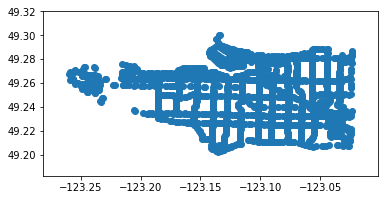

In [33]:
stop_geo.plot()

In [34]:
#initializing base map
m = folium.Map(location=[49.26, -123.11], zoom_start=11)

#adding a tile layer
folium.TileLayer('stamentoner').add_to(m)

#adding marker cluster plugin to map
mc = MarkerCluster(name='Base Layer', control=False)
m.add_child(mc)

#creating subgroups for markers so they can be toggled on/off.
Bus_Stops = FeatureGroupSubGroup(mc, 'Bus Stops', show=True)
m.add_child(Bus_Stops)

#adding markers per group
for bus_stop in stop_geo.iterrows():

        coord = (round(bus_stop[1].geometry.y,4),
                round(bus_stop[1].geometry.x,4))
        
        stop_name = bus_stop[1]['stop_name']
        
        stop_number = "Stop Number: "+bus_stop[1]['stop_no']
        
        stop_routes = "Routes: "+bus_stop[1]['routes']

        folium.Marker(coord,
                      popup= stop_number+'<br/><br/>'+stop_name+'<br/><br/>'+stop_routes).add_to(Bus_Stops)
        

#adding layer control for toggling layers on and off
folium.LayerControl().add_to(m)

m

## Getting Neighbourhood Data

Loading geospatial neighbourhood data from: https://data.vancouver.ca/datacatalogue/localAreaBoundary.htm

In [212]:
neighbourhoods = gpd.read_file("local_area_boundary.shp")

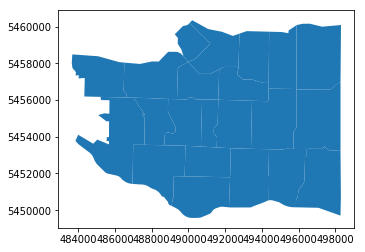

In [213]:
neighbourhoods.plot()

In [214]:
neighbourhoods.crs

{'init': 'epsg:26910'}

In [215]:
neighbourhoods.sample(5)

MAPID          NAME                                           geometry
13    SC  South Cambie  POLYGON ((491556.708018563 5453913.232452564, ...
20   STR    Strathcona  POLYGON ((492779.9065237215 5459618.3627329, 4...
0    SUN        Sunset  POLYGON ((492208.4021460207 5450157.053499949,...
9   MARP       Marpole  POLYGON ((492208.4021460207 5450157.053499949,...
2     RP    Riley Park  POLYGON ((492310.7074588875 5453376.090940117,...

In [216]:
neighbourhoods.shape

(22, 3)

Loading in census tract shapefiles

In [217]:
census_tracts = gpd.read_file("lct_000b16a_e.shp")

In [218]:
census_tracts.sample(10)

CTUID   CTNAME PRUID                                   PRNAME  \
3297  8350065.02  0065.02    48                                  Alberta   
559   4620311.00  0311.00    24                          Quebec / Québec   
2305  5350576.49  0576.49    35                                  Ontario   
287   4620117.00  0117.00    24                          Quebec / Québec   
5670  9330182.06  0182.06    59  British Columbia / Colombie-Britannique   
953   5350360.00  0360.00    35                                  Ontario   
3499  9150007.00  0007.00    59  British Columbia / Colombie-Britannique   
3356  8350016.02  0016.02    48                                  Alberta   
5564  9330184.07  0184.07    59  British Columbia / Colombie-Britannique   
4673  9150019.02  0019.02    59  British Columbia / Colombie-Britannique   

     CMAUID CMAPUID    CMANAME CMATYPE  \
3297    835   48835   Edmonton       B   
559     462   24462   Montréal       B   
2305    535   35535    Toronto       B   
287     462   24462   Montréal       B   
5670    933   59933  Vancouver       B   
953     535   35535    Toronto       B   
3499    915   59915    Kelowna       B   
3356    835   48835   Edmonton       B   
5564    933   59933  Vancouver       B   
4673    915   59915    Kelowna       B   

                                               geometry  
3297  POLYGON ((4813937.71143 2174298.81143, 4813918...  
559   POLYGON ((7633565.919685 1239592.37504, 763354...  
2305  POLYGON ((7187647.76 927105.394285, 7187616.33...  
287   POLYGON ((7627059.82 1242167.04857, 7627050.20...  
5670  POLYGON ((4041977.385715 1982912.75143, 404211...  
953   POLYGON ((7239613.985715 946146.642855, 723963...  
3499  POLYGON ((4290161.605715 1947986.154285, 42901...  
3356  POLYGON ((4815587.13143 2162948.73143, 4815564...  
5564  POLYGON ((4030168.73143 1982549.502855, 403002...  
4673  POLYGON ((4287447.63143 1951835.114285, 428746...

In [219]:
census_tracts = census_tracts.query('CMANAME == "Vancouver"')

In [220]:
census_tracts.sample(10)

CTUID   CTNAME PRUID                                   PRNAME  \
4028  9330403.07  0403.07    59  British Columbia / Colombie-Britannique   
5680  9330185.07  0185.07    59  British Columbia / Colombie-Britannique   
2919  9330149.02  0149.02    59  British Columbia / Colombie-Britannique   
1747  9330002.04  0002.04    59  British Columbia / Colombie-Britannique   
3003  9330284.01  0284.01    59  British Columbia / Colombie-Britannique   
5457  9330183.05  0183.05    59  British Columbia / Colombie-Britannique   
4187  9330505.01  0505.01    59  British Columbia / Colombie-Britannique   
5629  9330185.15  0185.15    59  British Columbia / Colombie-Britannique   
522   9330400.04  0400.04    59  British Columbia / Colombie-Britannique   
2150  9330149.07  0149.07    59  British Columbia / Colombie-Britannique   

     CMAUID CMAPUID    CMANAME CMATYPE  \
4028    933   59933  Vancouver       B   
5680    933   59933  Vancouver       B   
2919    933   59933  Vancouver       B   
1747    933   59933  Vancouver       B   
3003    933   59933  Vancouver       B   
5457    933   59933  Vancouver       B   
4187    933   59933  Vancouver       B   
5629    933   59933  Vancouver       B   
522     933   59933  Vancouver       B   
2150    933   59933  Vancouver       B   

                                               geometry  
4028  POLYGON ((4045349.4 1983958.434285, 4045306.17...  
5680  POLYGON ((4027912.262855 1981714.234285, 40279...  
2919  POLYGON ((4008437.182855 1997792.282855, 40084...  
1747  POLYGON ((4019016.357145 1998265.42, 4019057.9...  
3003  POLYGON ((4033237.065715 1995467.797145, 40332...  
5457  POLYGON ((4037883.98857 1976606.954285, 403784...  
4187  POLYGON ((4046919.605715 1978883.2, 4047000.86...  
5629  POLYGON ((4030053.31143 1986261.125715, 403011...  
522   POLYGON ((4055584.10857 1980062.965715, 405592...  
2150  POLYGON ((4009529.897145 1997564.194285, 40093...

In [221]:
census_tracts.shape

(478, 9)

In [222]:
len(census_tracts.CTNAME.unique())

478

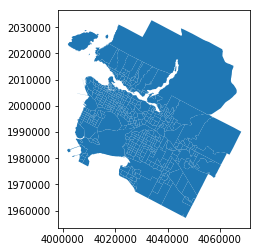

In [223]:
census_tracts.plot()

Loading in median houshold income info from: http://www12.statcan.gc.ca/census-recensement/2016/dp-pd/dv-vd/cpdv-vdpr/index-eng.cfm?configBase=https://www97.statcan.gc.ca/Geocortex/Essentials/REST/sites/CPDV/viewers/CensusProgram_gvh/virtualdirectory/Resources/Config/Default&focusGeographyId=2016A000011124&visualizationGeographyLevelId=507&activeIndicatorId=1025&activeThemeId=5&extent=4002810.22342162,1989809.05337151,4043670.25723544,2015446.72164685&comparisonGeographyList=

In [224]:
census_mhi = pd.read_csv("census_mthi_2015.csv")

In [225]:
census_mhi.sample()

Location  \
4108  0806.01 [CT] in Montréal [CMA] (Que.)   

      Median total income of households in 2015 ($)  
4108                                        57984.0

In [226]:
census_mhi[census_mhi['Location'].str.contains("Vancouver")].shape

(478, 2)

In [227]:
census_mhi = census_mhi[census_mhi['Location'].str.contains("Vancouver")]

In [228]:
import re

In [229]:
census_mhi.Location = census_mhi.Location.str.extract('(\d\d\d\d\.\d\d)', expand=True)

In [230]:
col2 = 'Median total household income 2015'
col2 = col2.replace(" ", "_")

In [231]:
census_mhi.columns = ['CTNAME', col2]

In [232]:
census_tracts = census_tracts.merge(census_mhi, on="CTNAME")

In [233]:
census_tracts.sample()

CTUID   CTNAME PRUID                                   PRNAME CMAUID  \
40  9330180.03  0180.03    59  British Columbia / Colombie-Britannique    933   

   CMAPUID    CMANAME CMATYPE  \
40   59933  Vancouver       B   

                                             geometry  \
40  POLYGON ((4032073.294285 1972295.845715, 40327...   

    Median_total_household_income_2015  
40                             94950.0

In [234]:
census_tracts.shape

(478, 10)

In [235]:
census_tracts.isna().sum()

CTUID                                  0
CTNAME                                 0
PRUID                                  0
PRNAME                                 0
CMAUID                                 0
CMAPUID                                0
CMANAME                                0
CMATYPE                                0
geometry                               0
Median_total_household_income_2015    10
dtype: int64

In [236]:
census_tracts=census_tracts.fillna(0)

In [237]:
census_tracts.isna().sum()

CTUID                                 0
CTNAME                                0
PRUID                                 0
PRNAME                                0
CMAUID                                0
CMAPUID                               0
CMANAME                               0
CMATYPE                               0
geometry                              0
Median_total_household_income_2015    0
dtype: int64

In [238]:
census_tracts.crs

{'init': 'epsg:3347'}

In [239]:
neighbourhoods.crs

{'init': 'epsg:26910'}

In [240]:
census_tracts = census_tracts.to_crs({'init': 'epsg:26910'})

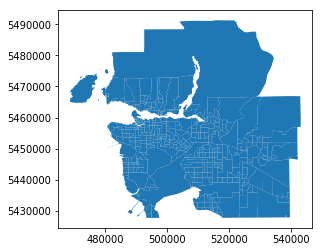

In [241]:
census_tracts.plot()

In [242]:
census_tracts.sample()

CTUID   CTNAME PRUID                                   PRNAME  \
226  9330183.01  0183.01    59  British Columbia / Colombie-Britannique   

    CMAUID CMAPUID    CMANAME CMATYPE  \
226    933   59933  Vancouver       B   

                                              geometry  \
226  POLYGON ((519345.242948871 5439271.163030094, ...   

     Median_total_household_income_2015  
226                             97280.0

In [262]:
census_tract_filtered = census_tracts[census_tracts['CTNAME'].str.contains("00")]

In [263]:
census_tract_filtered=census_tract_filtered[~census_tract_filtered.CTNAME.str.contains(r'01..\.')]
census_tract_filtered=census_tract_filtered[~census_tract_filtered.CTNAME.str.contains(r'02..\.')]
census_tract_filtered=census_tract_filtered[~census_tract_filtered.CTNAME.str.contains(r'03..\.')]
census_tract_filtered=census_tract_filtered[~census_tract_filtered.CTNAME.str.contains(r'04..\.')]
census_tract_filtered=census_tract_filtered[~census_tract_filtered.CTNAME.str.contains(r'05..\.')]

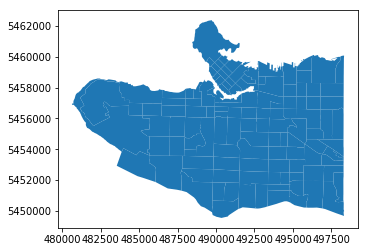

In [264]:
census_tract_filtered.plot()

In [265]:
census_tract_filtered.shape

(120, 10)

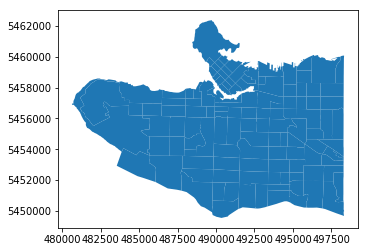

In [266]:
census_tract_filtered.plot()

Hurray!

## Mapping Median Household Income across Vancouver with Bus Stops

In [288]:
#initializing base map
m = folium.Map(location=[49.26, -123.11], zoom_start=11)

#adding a tile layer
folium.TileLayer('cartodbpositron').add_to(m)

#adding marker cluster plugin to map
mc = MarkerCluster(name='Base Layer', control=False)
m.add_child(mc)

#creating subgroups for markers so they can be toggled on/off.
Bus_Stops = FeatureGroupSubGroup(mc, 'Bus Stops', show=True)
m.add_child(Bus_Stops)

#adding markers per group
for bus_stop in stop_geo.iterrows():

        coord = (round(bus_stop[1].geometry.y,4),
                round(bus_stop[1].geometry.x,4))
        
        stop_name = bus_stop[1]['stop_name']
        
        stop_number = "Stop Number: "+bus_stop[1]['stop_no']
        
        stop_routes = "Routes: "+bus_stop[1]['routes']

        folium.Marker(coord,
                      popup= stop_number+'<br/><br/>'+stop_name+'<br/><br/>'+stop_routes).add_to(Bus_Stops)
        

In [289]:
#creating a geojson object with neighbourhood polygons to shade by median income and add to the base plot `m`.
census_shapes = folium.Choropleth(
    geo_data=census_tract_filtered,
    name='Median Household Income by Census Tract (2015)', #this text appears in the layercontrol
    data=census_tract_filtered, #this is our df
    columns=['CTNAME', 'Median_total_household_income_2015'], #which fields to map via choropleth
    key_on='feature.properties.CTNAME',  #key id
    fill_color='BuPu',
    fill_opacity=0.6,
    line_opacity=0.5,
    color='black',
    highlight=True,
    legend_name='Median Household Income by Census Tract (2015)'
).add_to(m)

#adding tooltip with neighbourhood name and median income to the polygon objects above
folium.features.GeoJsonTooltip(fields=['CTNAME', 'Median_total_household_income_2015'],
                               aliases=['Census Tract','Median Household Income by Census Tract (2015)'],
                               labels=True, 
                               sticky=True,
                               localize=True
                              ).add_to(census_shapes.geojson)

HeatMap(stop_geo[['lat','long']].as_matrix(),
        radius=15,
       name='HeatMap',
       show=True,
       control=True).add_to(m)
#source https://alysivji.github.io/getting-started-with-folium.html
#adding layer control for toggling layers on and off

/Users/js/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [290]:
#adding layer control for toggling layers on and off
folium.LayerControl().add_to(m)

m